<a href="https://colab.research.google.com/github/petre001/PET_Biomarkers/blob/main/notebooks/main5.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Predicting PET Biomarkers of Alzheimer’s Disease With MRI Using Deep Convolutional Neural Networks 
### Contributors: Jeffrey Petrella

This project uses transfer learning to train a ResNet18 model to identify amyloid PET biomarker status from MRI images. It should be run on a GPU

### Step 1: Link Notebook to GitHub

In [1]:
# Remove Colab default sample_data
!rm -r ./sample_data

# Clone GitHub files to colab workspace
repo_name = "PET_Biomarkers" # Enter repo name
git_path = 'https://github.com/petre001/PET_Biomarkers.git'
!git clone "{git_path}"

Cloning into 'PET_Biomarkers'...
remote: Enumerating objects: 307, done.
remote: Counting objects: 100% (178/178), done.
remote: Compressing objects: 100% (137/137), done.
remote: Total 307 (delta 67), reused 132 (delta 38), pack-reused 129
Receiving objects: 100% (307/307), 218.41 MiB | 14.41 MiB/s, done.
Resolving deltas: 100% (128/128), done.
Checking out files: 100% (56/56), done.


### Step 2: Install and Import Dependencies

In [2]:
# Change working directory to location of notebook
# import os
# notebook_dir = ''
# path_to_notebook = os.path.join(repo_name,notebook_dir)
# path_to_notebook
%cd "{repo_name}"

/content/PET_Biomarkers


In [3]:
# Install dependencies from requirements.txt file
!pip install -r "{'requirements.txt'}"

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 11.2 MB 9.1 MB/s 
     |████████████████████████████████| 990 kB 47.9 MB/s 
ERROR: Could not find a version that satisfies the requirement numpy==1.22.3 (from versions: 1.3.0, 1.4.1, 1.5.0, 1.5.1, 1.6.0, 1.6.1, 1.6.2, 1.7.0, 1.7.1, 1.7.2, 1.8.0, 1.8.1, 1.8.2, 1.9.0, 1.9.1, 1.9.2, 1.9.3, 1.10.0.post2, 1.10.1, 1.10.2, 1.10.4, 1.11.0, 1.11.1, 1.11.2, 1.11.3, 1.12.0, 1.12.1, 1.13.0rc1, 1.13.0rc2, 1.13.0, 1.13.1, 1.13.3, 1.14.0rc1, 1.14.0, 1.14.1, 1.14.2, 1.14.3, 1.14.4, 1.14.5, 1.14.6, 1.15.0rc1, 1.15.0rc2, 1.15.0, 1.15.1, 1.15.2, 1.15.3, 1.15.4, 1.16.0rc1, 1.16.0rc2, 1.16.0, 1.16.1, 1.16.2, 1.16.3, 1.16.4, 1.16.5, 1.16.6, 1.17.0rc1, 1.17.0rc2, 1.17.0, 1.17.1, 1.17.2, 1.17.3, 1.17.4, 1.17.5, 1.18.0rc1, 1.18.0, 1.18.1, 1.18.2, 1.18.3, 1.18.4, 1.18.5, 1.19.0rc1, 1.19.0rc2, 1.19.0, 1.19.1, 1.19.2, 1.19.3, 1.19.4, 1.19.5, 1.20.0rc1, 1.20.0rc2, 1.20.0, 1.20.

In [4]:
!git clone https://github.com/Project-MONAI/MONAI.git
%cd MONAI/
!pip install -e '.[all]'

Cloning into 'MONAI'...
remote: Enumerating objects: 26830, done.
remote: Counting objects: 100% (115/115), done.
remote: Compressing objects: 100% (84/84), done.
remote: Total 26830 (delta 42), reused 78 (delta 31), pack-reused 26715
Receiving objects: 100% (26830/26830), 49.13 MiB | 28.47 MiB/s, done.
Resolving deltas: 100% (20968/20968), done.
/content/PET_Biomarkers/MONAI
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Obtaining file:///content/PET_Biomarkers/MONAI
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
    Preparing wheel metadata ... done
     |████████████████████████████████| 17.9 MB 415 kB/s 
     |████████████████████████████████| 2.0 MB 38.2 MB/s 
     |████████████████████████████████| 316 kB 52.8 MB/s 
     |████████████████████████████████| 87 kB 7.2 MB/s 
     |████████████████████████████████| 4.7 MB 34.2 MB/s 
     |████████████████████████████████| 259 kB 51.6 MB/s 
   

In [5]:
import os
import urllib.request
import tarfile
import zipfile
import copy
import time
import numpy as np
import pandas as pd
from torchsummary import summary
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

import pydicom
import cv2
from PIL import Image

import torch
from torchvision import datasets, transforms
import torchvision
from torch.utils.data import DataLoader, Dataset
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim


In [6]:
import monai
from monai.data import DataLoader, ImageDataset, NumpyReader
from monai.transforms import AddChannel, Compose, RandRotate90, Resize, ScaleIntensity, EnsureType

pin_memory = torch.cuda.is_available()
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

TORCH_VERSION = ".".join(torch.__version__.split(".")[:2])
CUDA_VERSION = torch.__version__.split("+")[-1]
print("torch: ", TORCH_VERSION, "; cuda: ", CUDA_VERSION)

torch:  1.12 ; cuda:  cu113


### Step 3: Load Training and Test data

In [7]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [8]:
%cd /content/drive/MyDrive/test_mci_lmci_data

/content/drive/MyDrive/test_mci_lmci_data


In [9]:
# Create a list of images and labels
df = pd.read_csv('MCI_LMCI_Amyloid.csv')
images = df.iloc[:,0].to_list()
images = [i+'.npy' for i in images]
labels = df.iloc[:,10].to_list()

In [10]:
np.size(images[396:])
np.size(images)

493

In [11]:
# Define transforms
#train_transforms = Compose([ScaleIntensity(), AddChannel(), Resize((96, 96, 96)), RandRotate90(), EnsureType()])
#val_transforms = Compose([ScaleIntensity(), AddChannel(), Resize((96, 96, 96)), EnsureType()])

train_transforms = Compose([AddChannel(), Resize((96, 96, 96)), EnsureType()])
val_transforms = Compose([AddChannel(), Resize((96, 96, 96)), EnsureType()])

# Create training Dataset and DataLoader using first 396 images
batch_size = 2

train_ds = ImageDataset(image_files=images[:395], labels=labels[:395], transform=train_transforms, reader='NumpyReader')
train_loader = DataLoader(train_ds, batch_size=batch_size, shuffle=False, num_workers=2, pin_memory=torch.cuda.is_available())

# Create validation Dataset and DataLoader using the rest of the 21 images
val_ds = ImageDataset(image_files=images[396:], labels=labels[396:], transform=val_transforms, reader='NumpyReader')
val_loader = DataLoader(val_ds, batch_size=batch_size, shuffle=False, num_workers=2, pin_memory=torch.cuda.is_available())

# Set up dict for dataloaders
dataloaders = {'train':train_loader,'val':val_loader}

# Store size of training, validation and test sets
dataset_sizes = {'train':len(train_ds),'val':len(val_ds)}

<class 'monai.transforms.utility.array.AddChannel'>: Class `AddChannel` has been deprecated since version 0.8. please use MetaTensor data type and monai.transforms.EnsureChannelFirst instead.


In [12]:
print("image shape:", train_ds[0][0].shape)

image shape: (1, 96, 96, 96)


In [13]:
im, label = monai.utils.misc.first(train_loader)
print(f'Image type: {type(im)}')
print(f'Input batch shape: {im.shape}')
print(f'Label batch shape: {label.shape}')

Image type: <class 'monai.data.meta_tensor.MetaTensor'>
Input batch shape: (2, 1, 96, 96, 96)
Label batch shape: torch.Size([2])


In [14]:
# Set up a mapping dictionary
classes = ['Amyloid(-)','Amyloid(+)']
idx_to_class = {i:j for i,j in enumerate(classes)}
class_to_idx = {v:k for k,v in idx_to_class.items()}

In [15]:
# Create an iterator object from train_loader
iter_object = iter(train_loader)

(2, 1, 96, 96, 96)
(96, 96)


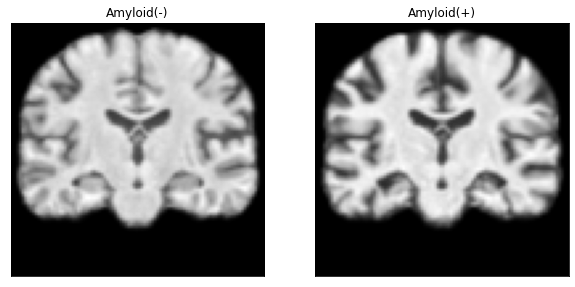

In [20]:
# Get next batch of training images
im, label = iter_object.next()
print(im.shape)
im = im.numpy() # Convert images to numpy for display
label = label.numpy()
print(im[:,0,40,:,:][0].shape)
# plot the images in the batch, along with the corresponding labels
fig = plt.figure(figsize=(10, 10))
for idx in range(batch_size):
    ax = fig.add_subplot(1, batch_size, idx+1, xticks=[], yticks=[])
    #ax.imshow(np.rot90(im[:,0,40,:,:][idx]), cmap='gray')
    ax.imshow(im[:,0,:,:,47][idx], cmap='gray')
    ax.set_title(idx_to_class[label[idx]])

As we see above, the 3D inputs in our DataLoader are of shape [N,C,H,W,D) where:

N = batch size
C = number of channels (1 in this case for grayscale)
H = image height
W = image width
D = image depth

###Step 4: Define our model architecture
We will used a pre-trained DenseNet 121 model for this task.

In [21]:
# Load a pre-trained DenseNet121
# We have a signle input channel, and we have 2 output classes
# We set spatial_dims=3 to indicate we want to use the version suitable for 3D input images
model = monai.networks.nets.DenseNet121(spatial_dims=3, in_channels=1, out_channels=2).to(device)

### Step 5: Train the Model

In [22]:
def train_model(model, criterion, optimizer, dataloaders, device, num_epochs=5):

    model = model.to(device) # Send model to GPU if available

    iter_num = {'train':0,'val':0} # Track total number of iterations

    best_metric = -1

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Get the input images and labels, and send to GPU if available
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # Zero the weight gradients
                optimizer.zero_grad()

                # Forward pass to get outputs and calculate loss
                # Track gradient only for training data
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # Backpropagation to get the gradients with respect to each weight
                    # Only if in train
                    if phase == 'train':
                        loss.backward()
                        # Update the weights
                        optimizer.step()

                # Convert loss into a scalar and add it to running_loss
                running_loss += loss.item() * inputs.size(0)
                # Track number of correct predictions
                running_corrects += torch.sum(preds == labels.data)

                # Iterate count of iterations
                iter_num[phase] += 1

            # Calculate and display average loss and accuracy for the epoch
            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]
            print('{} Loss: {:.4f} Acc: {:.4f}'.format(phase, epoch_loss, epoch_acc))

            # Save weights if accuracy is best
            if phase=='val':
                if epoch_acc > best_metric:
                    best_metric = epoch_acc
                    if not os.path.exists('./models'):
                        os.mkdir('./models')
                    torch.save(model.state_dict(),'models/3d_classification_model2.pth')
                    print('Saved best new model')

    print(f'Training complete. Best validation set accuracy was {best_metric}')
    
    return

In [23]:
# Use cross-entropy loss function
criterion = torch.nn.CrossEntropyLoss()
# loss_function = torch.nn.BCEWithLogitsLoss()  # also works with this data

# Use Adam adaptive optimizer
optimizer = torch.optim.Adam(model.parameters(), 1e-4)

# Train the model
epochs=5
train_model(model, criterion, optimizer, dataloaders, device, num_epochs=epochs)

Epoch 0/4
----------
train Loss: 0.6982 Acc: 0.5823
val Loss: 0.7064 Acc: 0.5670
Saved best new model
Epoch 1/4
----------
train Loss: 0.7056 Acc: 0.5747
val Loss: 0.7194 Acc: 0.5258
Epoch 2/4
----------
train Loss: 0.7055 Acc: 0.5797
val Loss: 0.7064 Acc: 0.4845
Epoch 3/4
----------
train Loss: 0.6975 Acc: 0.5975
val Loss: 0.6491 Acc: 0.6289
Saved best new model
Epoch 4/4
----------
train Loss: 0.6877 Acc: 0.6076
val Loss: 0.6633 Acc: 0.6289
Training complete. Best validation set accuracy was 0.6288659793814433


### Step 6: Load Model and Demo Images

In [24]:
%pwd

'/content/drive/MyDrive/test_mci_lmci_data'

In [25]:
# load demo images
# Create a list of demo_images and demo_labels
df = pd.read_csv('MCI_LMCI_Amyloid.csv')
images = df.iloc[396:,0].to_list()
images = [i+'.npy' for i in images]
labels = df.iloc[396:,10].to_list()

In [26]:
# load model
model2 = monai.networks.nets.DenseNet121(spatial_dims=3, in_channels=1, out_channels=2).to(device)
model2.load_state_dict(torch.load("models/3d_classification_model2.pth"))


<All keys matched successfully>

In [27]:
# make a dataset and dataloader for demo images
# Define transforms
demo_transforms = Compose([AddChannel(), Resize((96, 96, 96)), EnsureType()])

# Create demo Dataset and DataLoader
batch_size = 2
demo_ds = ImageDataset(image_files=images, labels=labels, transform=demo_transforms, reader='NumpyReader')
demo_loader = DataLoader(demo_ds, batch_size=batch_size, shuffle=False, num_workers=2, pin_memory=torch.cuda.is_available())


<class 'monai.transforms.utility.array.AddChannel'>: Class `AddChannel` has been deprecated since version 0.8. please use MetaTensor data type and monai.transforms.EnsureChannelFirst instead.


### Step 7: Make Predictions on Demo Images

In [28]:
# Display a batch of predictions
def visualize_results(model,images,labels,device):
    model = model.to(device) # Send model to GPU if available
    with torch.no_grad():
        model.eval()
        # Get a batch of demo images
        #images, labels = iter(demo_loader).next()
        images, labels = images.to(device), labels.to(device)
        # Get predictions
        _,preds = torch.max(model(images), 1)
        preds = np.squeeze(preds.cpu().numpy())
        labels = labels.cpu().numpy()
        images = images.cpu().numpy() # Convert images to numpy for display
            
    print(images[:,0,40,:,:][0].shape)
    # plot the images in the batch, along with the corresponding labels
    fig = plt.figure(figsize=(10, 10))
    for idx in range(batch_size):
        ax = fig.add_subplot(1, batch_size, idx+1, xticks=[], yticks=[])
        #ax.imshow(np.rot90(im[:,0,40,:,:][idx]), cmap='gray')
        ax.imshow(images[:,0,:,:,47][idx], cmap='gray')
        #ax.set_title(idx_to_class[label[idx]])
        ax.set_title("{} ({})".format(idx_to_class[preds[idx]], idx_to_class[labels[idx]]),
                    color=("green" if preds[idx]==labels[idx] else "red"))
    return


In [29]:
# Create iterator object
data_iter = iter(demo_loader)

(96, 96)


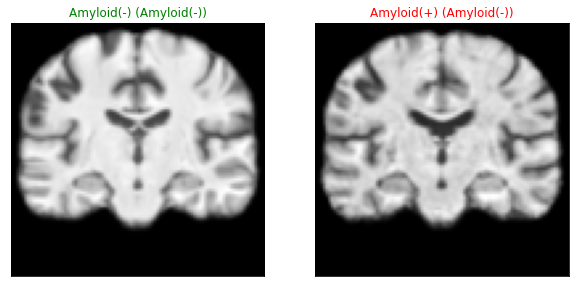

In [77]:
# Iterate the dataloader
images, labels = next(data_iter)
# Visualize results
visualize_results(model2,images,labels,device)